In [1]:
# Code for evaluating PRISSMM imaging report models
# execution on DFCI data is not currently possible as they contain protected health information.
# code is provided for demonstration and research purposes. it is not intended or optimized for production use.

In [2]:
import pandas as pd
import numpy as np

In [5]:
# open file containing human-curated data for curation set
with open('manual_label_analysis.csv') as f:
  label_analysis = pd.read_csv(f)
  

label_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 24 columns):
Unnamed: 0           17958 non-null int64
patient_id             17958 non-null int64
ehr_scan_date        17958 non-null object
PROC_DESCR           17958 non-null object
NARR_TXT             17958 non-null object
IMPRESS_TXT          17958 non-null object
os_date              17710 non-null object
died                 17958 non-null object
scan_to_os_date      17710 non-null float64
survived_6_months    17958 non-null int64
scan_type            17958 non-null float64
auto_type            17958 non-null float64
any_cancer           17958 non-null int64
redcap_resp_prog     11650 non-null float64
adrenal              17958 non-null int64
bone                 17958 non-null int64
brain                17958 non-null int64
liver                17958 non-null int64
lung                 17958 non-null int64
nodes                17958 non-null int64
peritoneum           17958 non-null

In [6]:
# combine NARR_TXT and IMPRESS_TXT (narrative and impression fields of imaging reports) and get rid of carriage returns
label_analysis = label_analysis.assign(imaging_text=label_analysis.NARR_TXT + ' ' + label_analysis.IMPRESS_TXT)
label_analysis['imaging_text'] = label_analysis.imaging_text.str.replace(r'\r\n', ' ')

print(label_analysis.info())

# drop duplicate reports; the most common reason for this was a CT chest/abdomen/pelvis with identical interpretations entered for the chest and the abdomen/pelvis
label_analysis = label_analysis.drop_duplicates(subset='imaging_text')
print(label_analysis.info())
print()

# drop 'reports' of outside scans, which just indicate that the scan was performed but do not contain useful text
label_analysis = label_analysis[label_analysis['imaging_text'].str.contains("it has been imported") == False]
print(label_analysis.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 25 columns):
Unnamed: 0           17958 non-null int64
patient_id             17958 non-null int64
ehr_scan_date        17958 non-null object
PROC_DESCR           17958 non-null object
NARR_TXT             17958 non-null object
IMPRESS_TXT          17958 non-null object
os_date              17710 non-null object
died                 17958 non-null object
scan_to_os_date      17710 non-null float64
survived_6_months    17958 non-null int64
scan_type            17958 non-null float64
auto_type            17958 non-null float64
any_cancer           17958 non-null int64
redcap_resp_prog     11650 non-null float64
adrenal              17958 non-null int64
bone                 17958 non-null int64
brain                17958 non-null int64
liver                17958 non-null int64
lung                 17958 non-null int64
nodes                17958 non-null int64
peritoneum           17958 non-null

In [7]:
import keras
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# get training/validation/test splits

with open('training_ids.csv') as f:
  training_ids = pd.read_csv(f)

with open('validation_ids.csv') as f:
  validation_ids = pd.read_csv(f)

with open('truetest_ids.csv') as f:
  test_ids = pd.read_csv(f)

  

training_data = label_analysis[label_analysis['patient_id'].isin(training_ids.patient_id)]
validation_data = label_analysis[label_analysis['patient_id'].isin(validation_ids.patient_id)]
test_data = label_analysis[label_analysis['patient_id'].isin(test_ids.patient_id)]

# set maximum length of imaging report in words
maxlen = 1000

In [9]:
# helper function to plot confusion matrix
# based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np
    import matplotlib as mpl
    import plotly.plotly as py
    import plotly.tools as tls

    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [10]:
# intended for demonstration/research, not production
# (not robust to different variable naming conventions, file locations, etc)
# graphing code based in part on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python/47562197 and https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


def evaluate_test(target):
  
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  from keras.preprocessing import sequence
  from keras.models import Sequential, Model
  from keras.layers import Input, Dense, Dropout, Activation, concatenate, Average
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  import plotly.plotly as py
  import plotly.tools as tls
  import numpy as np
  import pickle
  
  # evaluate only on the test set
  analysis_data = test_data.assign(outcome=test_data[target])

  # load tokenizer
  with open('models/tokenizer.pickle') as handle:
      tokenizer = pickle.load(handle)  
  
  x_test = tokenizer.texts_to_sequences(analysis_data.imaging_text)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  y_test = analysis_data['outcome']
  y_test_anycancer = analysis_data['any_cancer']
  
  # get previously trained model
  from keras.models import load_model
  import os
  
  model = load_model(target+'.model')

  y_pred = model.predict(x_test)
  
  review_outcome = analysis_data.assign(prob_outcome=y_pred)

  from keras.preprocessing import sequence
  # evaluate model auc
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import classification_report
  from sklearn.metrics import precision_recall_curve
  from sklearn.metrics import auc
  from sklearn.metrics import roc_curve

  print("AUC " + str(roc_auc_score(y_test, y_pred)))
  #print("F1 " + str(f1_score(y_test, y_pred)))

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.title('Receiver Operating Characteristic: ' + target)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  from sklearn.metrics import average_precision_score
  average_precision = average_precision_score(y_test, y_pred)

  print('Average precision score: {0:0.2f}'.format(
        average_precision))
    
  import matplotlib.pyplot as plt
  from sklearn.utils.fixes import signature

  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

  # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
  step_kwargs = ({'step': 'post'}
                 if 'step' in signature(plt.fill_between).parameters
                 else {})

  prob_outcome = (review_outcome['outcome'].value_counts()/len(review_outcome.index))[1]
  plt.plot(recall, precision, color='b')
  plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
  # plt.step(recall, precision, color='b', alpha=0.2,
  #          where='post')
  # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Recall (Sensitivity)')
  plt.ylabel('Precision (PPV)')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(target+': 2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
  plt.show()
  
  
  # best F1
  F1 = 2*((precision*recall)/(precision+recall))
  print("Best F1 for " + target + ":")
  print(max(F1))
  # threshold for best F1
  bestF1_thresh = np.argmax(F1)
  print("Threshold for best F1 in validation:")
  print(thresholds[bestF1_thresh])
  
  print("Threshold for best F1 in cross-validation:")
  crossval_thresholds = {'any_cancer':0.437538,
                        'response':0.35106,
                        'progression':0.37709,
                        'liver':0.37446,
                        'bone':0.397050,
                        'brain':0.4088236,
                         'nodes':0.27413597,
                         'adrenal':0.349509629 }

  
  # predictions
  review_outcome['bestF1_thresh'] = crossval_thresholds[target]
  review_outcome = review_outcome.assign(pred_outcome_best_f1_thresh = np.where(review_outcome.prob_outcome >= review_outcome.bestF1_thresh,1,0))
  review_outcome = review_outcome.assign(pred_outcome_05_thresh = np.where(review_outcome.prob_outcome >= 0.5,1,0))
  
  # confusion matrix
  print("Confusion matrix at best F1 thresh:")
  from sklearn.metrics import confusion_matrix
  cnf_matrix = confusion_matrix(y_test, review_outcome['pred_outcome_best_f1_thresh'])
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix for ' + target + ', without normalization')
  print("Metrics at best F1 thresh (specificity is recall for negative class):")
  from sklearn.metrics import classification_report
  print(classification_report(y_test, review_outcome['pred_outcome_best_f1_thresh'], target_names=['No','Yes']))
  

  
  
  
  print("Confusion matrix at 0.5 thresh:")
  from sklearn.metrics import confusion_matrix
  cnf_matrix = confusion_matrix(y_test, review_outcome['pred_outcome_05_thresh'])
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix for ' + target + ', without normalization')
  print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
  print(classification_report(y_test, review_outcome['pred_outcome_05_thresh'], target_names=['No','Yes']))
  
  
  
  # Plot normalized confusion matrix
  #   plt.figure()
  #   plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
  #                         title='Normalized confusion matrix')

  
  # plot threshold vs ppv curve
  plt.plot(thresholds, precision[0:len(precision)-1], color='b')
  # plt.step(recall, precision, color='b', alpha=0.2,
  #          where='post')
  # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Threshold probability')
  plt.ylabel('Precision (PPV)')
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.title('Threshold vs precision: '+target)
  plt.show()
  
  # histogram
  plt.hist(review_outcome.prob_outcome)
  plt.title("Histogram")
  plt.xlabel("Predicted probability of "+target)
  plt.ylabel("Frequency")
  plt.show()
  


  
  with open(target+'_review_test.csv', 'w') as f:
    review_outcome.to_csv(f, index=False)
  import os

  



/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9156890894175554


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



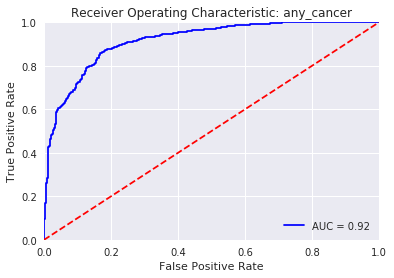

Average precision score: 0.94


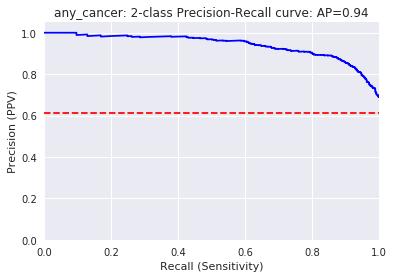

Best F1 for any_cancer:
0.8795370857443451
Threshold for best F1 in validation:
0.36583456
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[460 123]
 [104 816]]


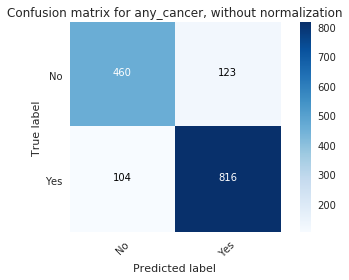

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.82      0.79      0.80       583
        Yes       0.87      0.89      0.88       920

avg / total       0.85      0.85      0.85      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[478 105]
 [125 795]]


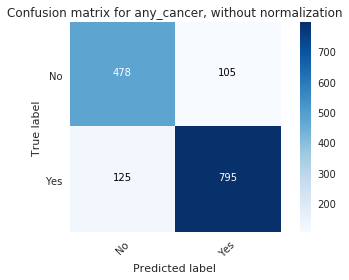

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.79      0.82      0.81       583
        Yes       0.88      0.86      0.87       920

avg / total       0.85      0.85      0.85      1503



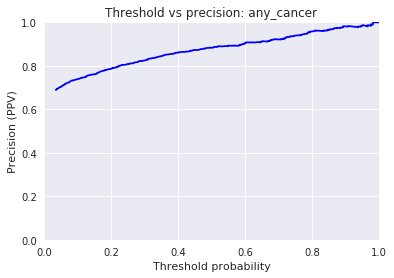

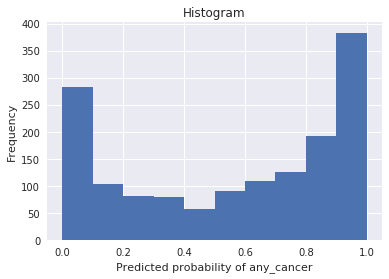

In [11]:
evaluate_test(target="any_cancer")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9489317754416253


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



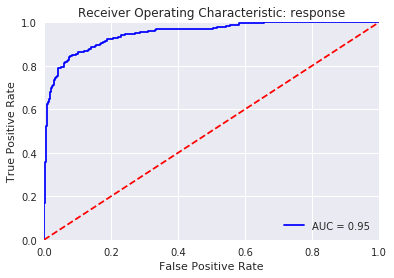

Average precision score: 0.82


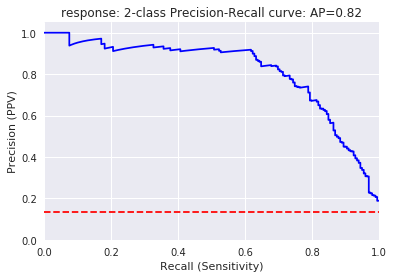

Best F1 for response:
0.7639902676399025
Threshold for best F1 in validation:
0.19085939
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1274   30]
 [  60  139]]


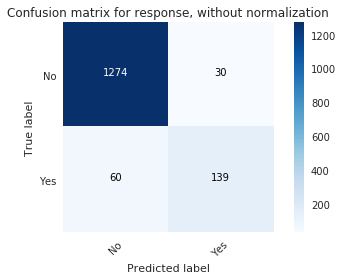

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.96      0.98      0.97      1304
        Yes       0.82      0.70      0.76       199

avg / total       0.94      0.94      0.94      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1288   16]
 [  74  125]]


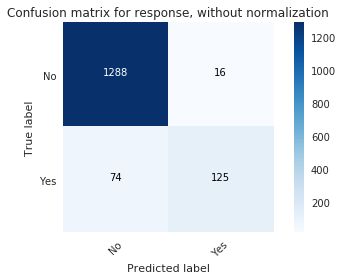

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.95      0.99      0.97      1304
        Yes       0.89      0.63      0.74       199

avg / total       0.94      0.94      0.94      1503



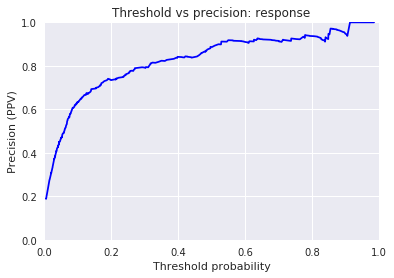

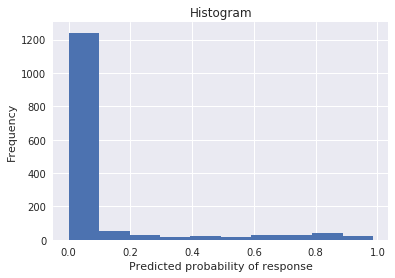

In [12]:
evaluate_test(target="response")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9407653380521807


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



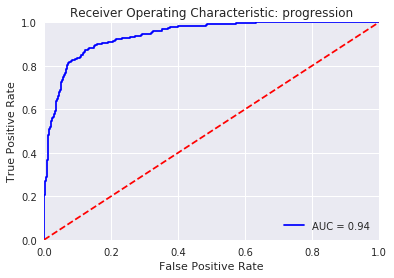

Average precision score: 0.83


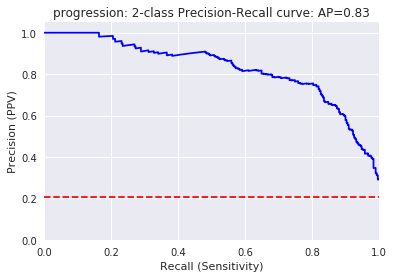

Best F1 for progression:
0.7796610169491525
Threshold for best F1 in validation:
0.4401157
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1071  121]
 [  51  260]]


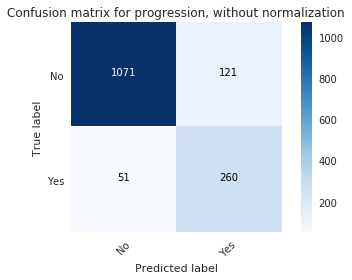

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.95      0.90      0.93      1192
        Yes       0.68      0.84      0.75       311

avg / total       0.90      0.89      0.89      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1124   68]
 [  83  228]]


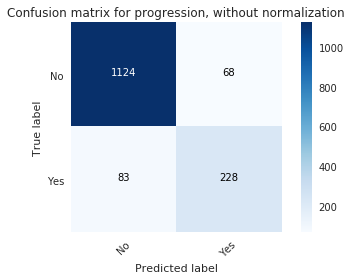

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.93      0.94      0.94      1192
        Yes       0.77      0.73      0.75       311

avg / total       0.90      0.90      0.90      1503



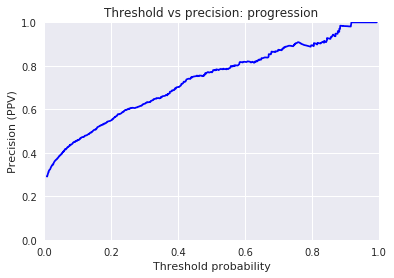

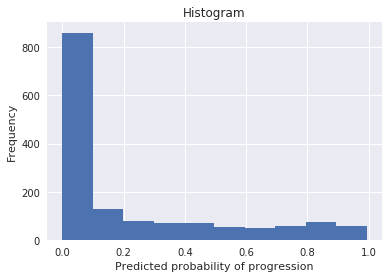

In [13]:
evaluate_test(target="progression")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9768973998594519


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



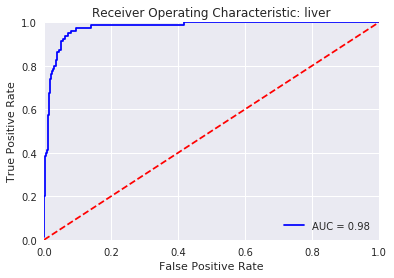

Average precision score: 0.74


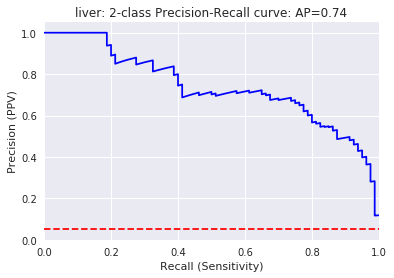

Best F1 for liver:
0.7108433734939759
Threshold for best F1 in validation:
0.42252612
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1392   31]
 [  19   61]]


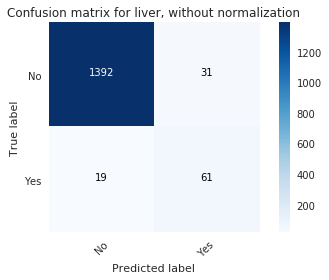

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.99      0.98      0.98      1423
        Yes       0.66      0.76      0.71        80

avg / total       0.97      0.97      0.97      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1403   20]
 [  31   49]]


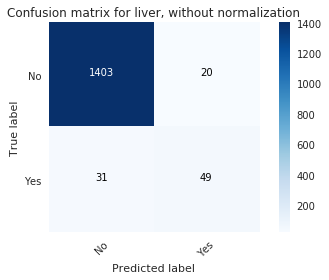

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.98      0.99      0.98      1423
        Yes       0.71      0.61      0.66        80

avg / total       0.96      0.97      0.96      1503



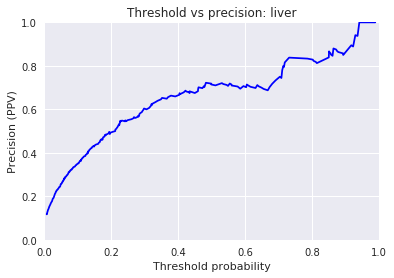

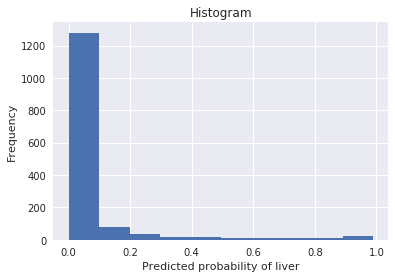

In [14]:
evaluate_test(target="liver")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9490662650602409


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



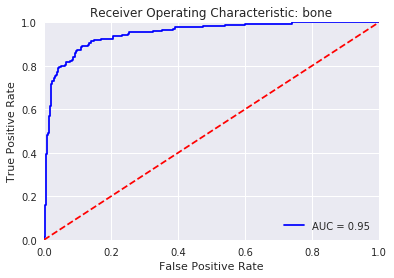

Average precision score: 0.75


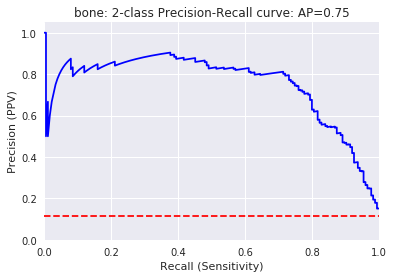

Best F1 for bone:
0.7619047619047618
Threshold for best F1 in validation:
0.4091651
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1291   37]
 [  47  128]]


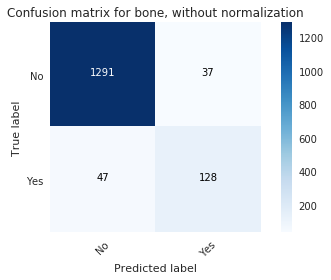

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.96      0.97      0.97      1328
        Yes       0.78      0.73      0.75       175

avg / total       0.94      0.94      0.94      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1302   26]
 [  65  110]]


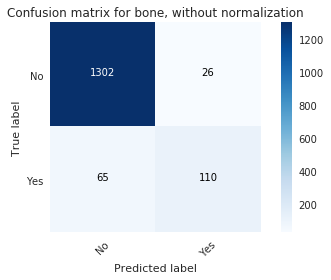

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.95      0.98      0.97      1328
        Yes       0.81      0.63      0.71       175

avg / total       0.94      0.94      0.94      1503



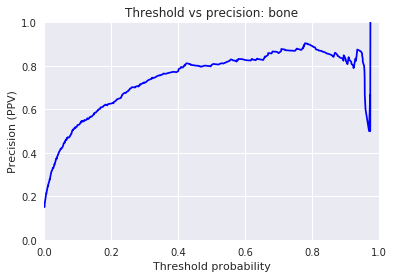

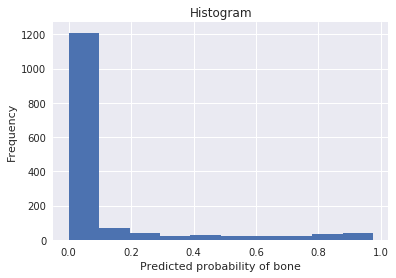

In [15]:
evaluate_test(target="bone")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9728684559208701


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



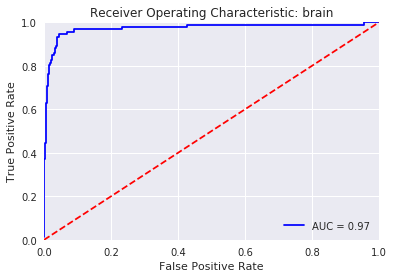

Average precision score: 0.83


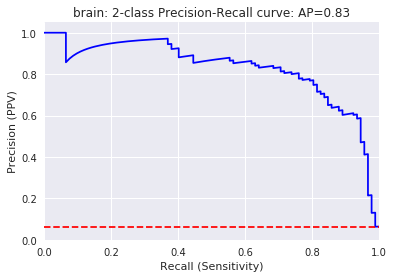

Best F1 for brain:
0.7872340425531915
Threshold for best F1 in validation:
0.5416521
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1376   35]
 [  15   77]]


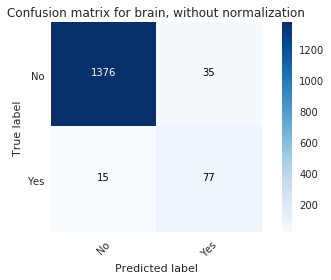

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.99      0.98      0.98      1411
        Yes       0.69      0.84      0.75        92

avg / total       0.97      0.97      0.97      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1386   25]
 [  17   75]]


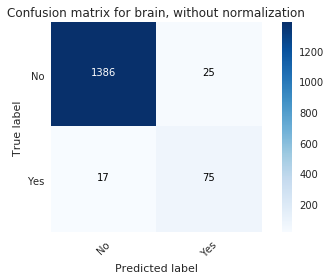

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.99      0.98      0.99      1411
        Yes       0.75      0.82      0.78        92

avg / total       0.97      0.97      0.97      1503



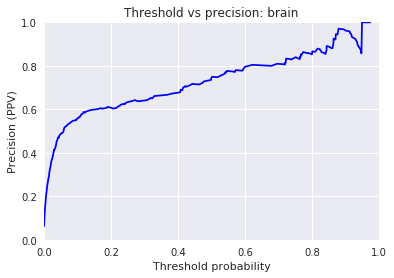

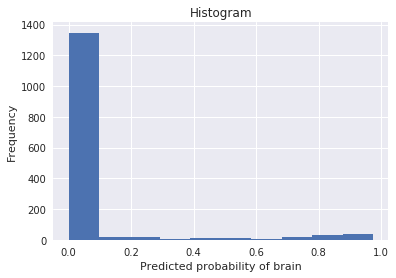

In [16]:
evaluate_test(target="brain")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.8937224139957893


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



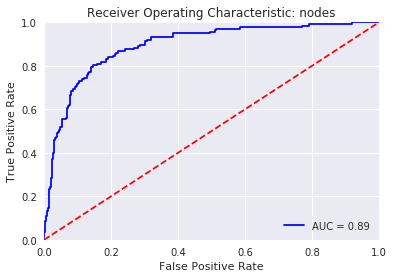

Average precision score: 0.49


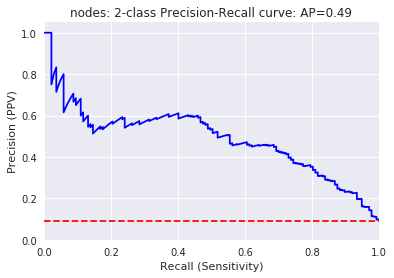

Best F1 for nodes:
0.5497076023391814
Threshold for best F1 in validation:
0.3338433
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1220  146]
 [  37  100]]


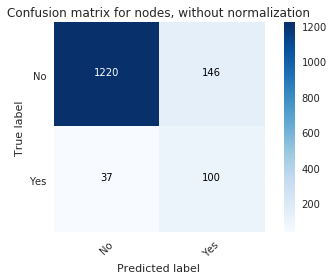

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.97      0.89      0.93      1366
        Yes       0.41      0.73      0.52       137

avg / total       0.92      0.88      0.89      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1327   39]
 [  81   56]]


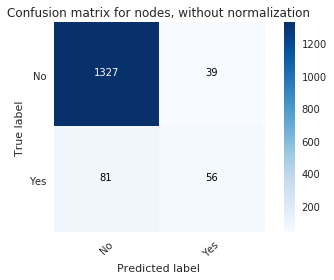

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.94      0.97      0.96      1366
        Yes       0.59      0.41      0.48       137

avg / total       0.91      0.92      0.91      1503



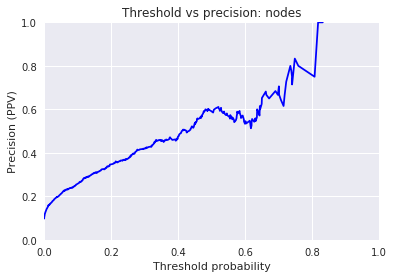

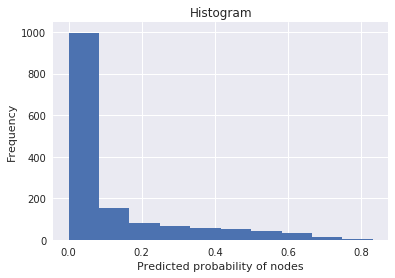

In [17]:
evaluate_test(target="nodes")

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



AUC 0.9735476785579035


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



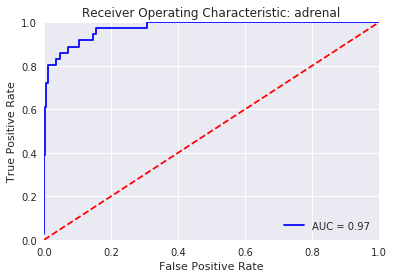

Average precision score: 0.73


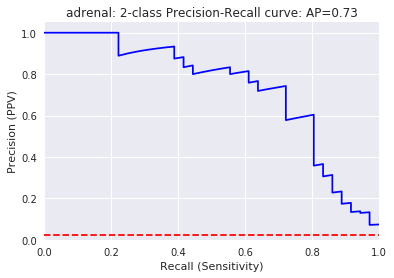

Best F1 for adrenal:
0.732394366197183
Threshold for best F1 in validation:
0.28607026
Threshold for best F1 in cross-validation:
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1460    7]
 [  13   23]]


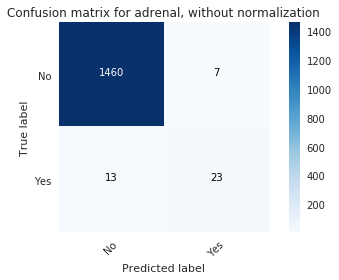

Metrics at best F1 thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.99      1.00      0.99      1467
        Yes       0.77      0.64      0.70        36

avg / total       0.99      0.99      0.99      1503

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1463    4]
 [  16   20]]


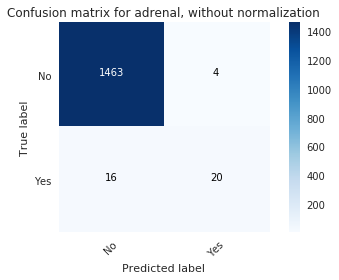

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
             precision    recall  f1-score   support

         No       0.99      1.00      0.99      1467
        Yes       0.83      0.56      0.67        36

avg / total       0.99      0.99      0.99      1503



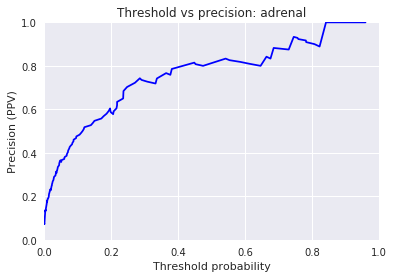

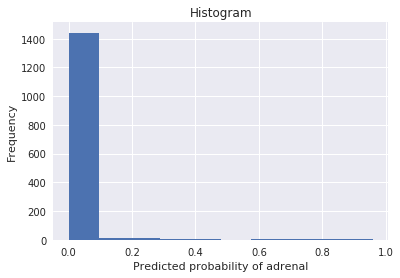

In [18]:
evaluate_test(target="adrenal")